### Sparse Softmax Operator
This is an example of how to create and tune a sparse softmax operator.

In [1]:
import torch
import matplotlib.pyplot as plt
import sparta

First, determine the height (batch size) and width (dimensions) of the input tensor and create a dense softmax operator.

In [2]:
H, W = 1024, 1024
dense_softmax = torch.nn.Softmax(dim=-1)

Then generate a mask with block size $32\times32$, in which 90% of blocks are empty. 

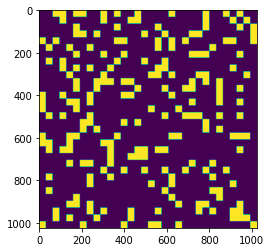

In [3]:
mask = sparta.testing.block_mask((H, W), block=(32, 32), sparsity=0.9).cuda()
plt.imshow(mask.cpu().numpy())

Create a ```sparta.nn.SparseSoftmax``` operator using the dense operator and the mask.

Next, tune the sparse operator using a sample input (to determine the shape). This step may take several minutes.

In [4]:
x = torch.rand((H, W)).cuda()
sparse_softmax = sparta.nn.SparseSoftmax(dense_softmax, mask=mask)
sparta.nn.tune(sparse_softmax, sample_inputs=[x])

==================== Tuning ====================
----- Implementation: sparta; Search space: 64 -----
#1: ROW_TILE_VALUE=4, BLOCK_SIZE_W_VALUE=8, BLOCK_SIZE_H_VALUE=8
Latency: 0.031027 ms
#2: ROW_TILE_VALUE=4, BLOCK_SIZE_W_VALUE=8, BLOCK_SIZE_H_VALUE=16
Latency: 0.031037 ms
#3: ROW_TILE_VALUE=4, BLOCK_SIZE_W_VALUE=8, BLOCK_SIZE_H_VALUE=32
Latency: 0.031306 ms
#4: ROW_TILE_VALUE=4, BLOCK_SIZE_W_VALUE=8, BLOCK_SIZE_H_VALUE=64
An error occured
#5: ROW_TILE_VALUE=4, BLOCK_SIZE_W_VALUE=16, BLOCK_SIZE_H_VALUE=8
Latency: 0.019574 ms
#6: ROW_TILE_VALUE=4, BLOCK_SIZE_W_VALUE=16, BLOCK_SIZE_H_VALUE=16
Latency: 0.019741 ms
#7: ROW_TILE_VALUE=4, BLOCK_SIZE_W_VALUE=16, BLOCK_SIZE_H_VALUE=32
Latency: 0.02032 ms
#8: ROW_TILE_VALUE=4, BLOCK_SIZE_W_VALUE=16, BLOCK_SIZE_H_VALUE=64
An error occured
#9: ROW_TILE_VALUE=4, BLOCK_SIZE_W_VALUE=32, BLOCK_SIZE_H_VALUE=8
Latency: 0.014678 ms
#10: ROW_TILE_VALUE=4, BLOCK_SIZE_W_VALUE=32, BLOCK_SIZE_H_VALUE=16
Latency: 0.015094 ms
#11: ROW_TILE_VALUE=4, BLOCK_SIZE

The sparse softmax operator is ready to use. Let's compare it with the dense operator.

In [ ]:
dense_latency = sparta.testing.test_latency(dense_softmax, inputs=[x])
print(f'Dense linear operator latency: {dense_latency} ms')
sparse_latency = sparta.testing.test_latency(sparse_softmax, inputs=[x])
print(f'Sparse linear operator latency: {sparse_latency} ms')

Dense linear operator latency: 0.047839999198913574 ms
Sparse linear operator latency: 0.08195199966430664 ms
